# Реферат по предмету Прикладное машинное обучение

Выполнил Козлов Михаил Владимирович, 523 группа

2018, осенний семестр

# Содержательная задача

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/5708/media/halloween-660x.png
)

Извлеките свои стержни для дозирования, электромагнитные датчики и… машины для повышения градиента. Kaggle часто посещается, и нам нужна ваша помощь. После месяца научных наблюдений и тщательных измерений мы определили, что 900 гулей, призраков и гоблинов наводняют наши залы и пугают наших исследователей данных. Когда чеснок, вежливые просьбы и обратная психология не сработали, стало ясно, что машинное обучение - единственный ответ на изгнание наших нежелательных гостей.

Итак, теперь настал час отдать данные, которые мы собрали, в ваши руки. Нам удалось идентифицировать 371 ужасное существо, но нам нужна ваша помощь, чтобы победить остальных. И только точный алгоритм классификации может помешать им. Используйте измерения длины кости, тяжесть гнили, степень бездуховности и другие характеристики, чтобы отличить (и погасить) злоумышленников. Вы, охотники за привидениями, отвечаете на вызов?




В задаче дана размеченная база призраков, обладающих следующими признаками:


> ID - номер существа

> bone_length - средняя длина кости у существа, нормализованная от 0 до 1

> rotting_flesh - процент гниющей плоти у существа, число от 0 до 1

> hair_length - средняя длина волос существа, нормализованная от 0 до 1

> has_soul - процент души в существе, число от 0 до 1

> color - диминирующий цвет существа (белый, чёрный, прозрачный, синий, зелёный, кровавый)

> type - тип существа (Призрак, Гоблин, Гуль) (ЦЕЛЕВОЙ ПРИЗНАК)




# Формальная постановка задачи

Дана выборка *X = {x1, ..., xn}*

и ответы (классы) *Y = {y1, ..., yn}, yi = y(xi)*, i принадлежит множеству [1, ..., K] (в данной задаче K = 3)

Надо найти алгоритм *а: X -> Y,* находящий функцию, приближающую функцию Y на всём множестве объектов X.

Показателем качества выбрана метрика
> Accuracy: *1 / n ( sum( [a(xi) = yi] ) )* *(TP + TN) / (TP + TN + FP + FN)*

> *Recall = TN / (TN + FP)*

> *Precision = TP / (TP + FP)*


   0        1
   
0  TN     FN

1  FP     TP


In [0]:
# Импортируем библиотеки
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

import graphviz

#Анализ и преобразование данных

In [230]:
# Загружаем файл с выборками
from google.colab import files
uploaded = files.upload()

In [0]:
train_data_orig = pd.read_csv('train.csv')
test_data_orig = pd.read_csv('test.csv')

In [232]:
print("Shape of Training Data")
print(train_data_orig.shape)
print()

print("Shape of Testing Data")
print(test_data_orig.shape)

Shape of Training Data
(371, 7)

Shape of Testing Data
(529, 6)


In [233]:
print("Columns in Training Data")
print(train_data_orig.columns)
print()

print("Columns in Testing Data")
print(test_data_orig.columns)

Columns in Training Data
Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color', 'type'],
      dtype='object')

Columns in Testing Data
Index(['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul',
       'color'],
      dtype='object')


С помощью методов .info() и .isnull() посмотрим на тип данных и выясним, есть ли в них пропуски.

In [234]:
train_data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [235]:
train_data_orig.isnull().sum()

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

In [236]:
train_data_orig.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


Признак id не влияет на классификацию, поэтому удалим его.

In [0]:
train_data = train_data_orig.drop(['id'], axis = 1)
test_data = test_data_orig.drop(['id'], axis = 1)

Из графика ниже видно, что в тренировочной выборке почти равное количество объектов из разных классов.

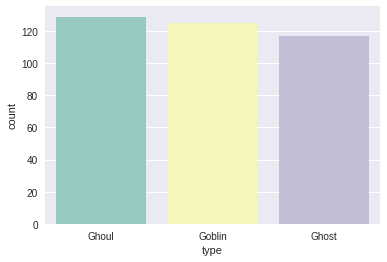

In [238]:
sns.countplot(x='type', data=train_data, palette='Set3')

In [239]:
train_data.describe()

,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000
mean,0.434160,0.506848,0.529114,0.471392
std,0.132833,0.146358,0.169902,0.176129
min,0.061032,0.095687,0.134600,0.009402
25%,0.340006,0.414812,0.407428,0.348002
50%,0.434891,0.501552,0.538642,0.466372
75%,0.517223,0.603977,0.647244,0.600610
max,0.817001,0.932466,1.000000,0.935721


In [240]:
test_data.describe()

,bone_length,rotting_flesh,hair_length,has_soul
count,529.000000,529.000000,529.000000,529.000000
mean,0.425474,0.503637,0.517288,0.464096
std,0.136079,0.158552,0.171727,0.179659
min,0.000000,0.000000,0.000000,0.000000
25%,0.329383,0.393987,0.388189,0.338964
50%,0.421989,0.510065,0.520220,0.461294
75%,0.519024,0.605957,0.644824,0.584448
max,1.000000,1.000000,0.999841,1.000000


Посмотрим на категориальные признаки нашей модели: цвета и типы существ.

In [241]:
print(np.sort(train_data['color'].unique()))
print(np.sort(test_data['color'].unique()))

['black' 'blood' 'blue' 'clear' 'green' 'white']
['black' 'blood' 'blue' 'clear' 'green' 'white']


In [242]:
print(np.sort(train_data['type'].unique()))

['Ghost' 'Ghoul' 'Goblin']


На графике ниже можно наблюдать распределение признаков по классам и зависимость признаков друг от друга.

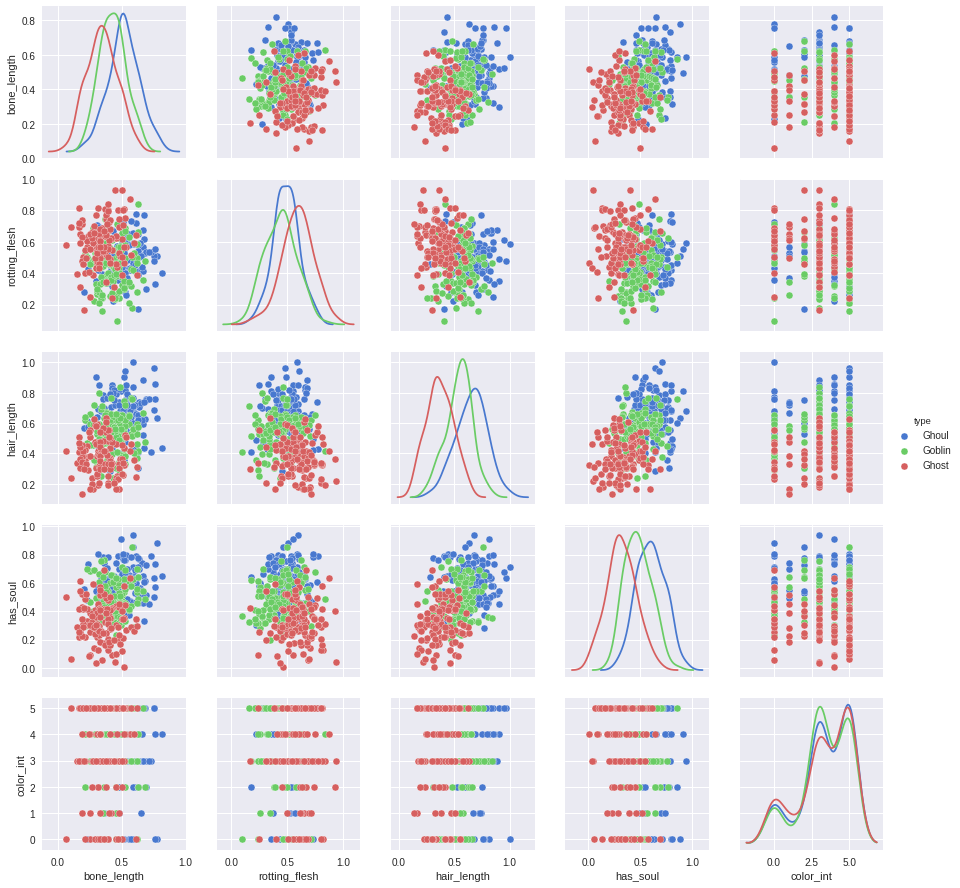

In [243]:
color_le = preprocessing.LabelEncoder()
color_le.fit(train_data['color'])
train_data['color_int'] = color_le.transform(train_data['color'])

_ = sns.pairplot(train_data.drop('color', axis = 1), hue = 'type', palette = 'muted', diag_kind='kde')

train_data.drop('color_int', axis = 1, inplace = True)

На данном графике можно наблюдать корреляцию признаков.

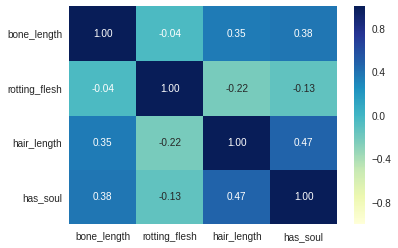

In [244]:
_ = sns.heatmap(train_data.corr(), annot = True, fmt = ".2f", cmap = 'YlGnBu')

На графике ниже можно посмотреть изменение переменных для разных классов.

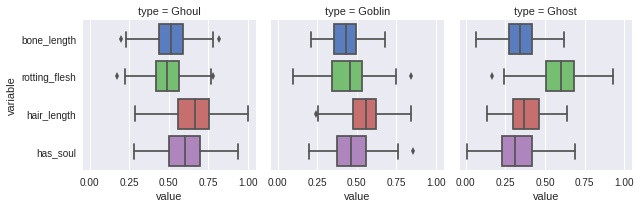

In [245]:
g = sns.FacetGrid(pd.melt(train_data, id_vars='type', value_vars = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']), col = 'type')
g = g.map(sns.boxplot, 'value', 'variable', palette = 'muted')

Разобьём нашу выборку на обучающую (*_train) и валидационную (*_test).

In [0]:
df = pd.get_dummies(train_data.drop('type', axis = 1))
X_train, X_test, y_train, y_test = train_test_split(df, train_data['type'], test_size = 0.25, random_state = 0)

# Сравниваемые подходы

В данной секции с помощью GridSearchCV будут найдены наилучшие параметры для разных классификаторов, а также вычислено время обучения и и Accuracy на валидационной выборке.

## DecisionTreeClassifier

Решающее дерево - структура, состоящая из листьев, веток и узлов. В каждом узле находится значение целевой переменной. В каждом узле находится атрибут, по которому выборка будет разбита, а на ветках находятся признаки переменной, по которой ведётся разбиение.

In [247]:
%%time
params = {'max_depth':[1, 3, 5, 7, 8, 9, 10]}
dt_clf = DecisionTreeClassifier(random_state = 0)
clf = GridSearchCV(dt_clf, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)
# dt_clf.fit(X_train, y_train)

CPU times: user 145 ms, sys: 28.8 ms, total: 174 ms
Wall time: 2.07 s


Best score: 0.6798561151079137
Best parameters: {'max_depth': 7}
              precision    recall  f1-score   support

       Ghost       0.71      0.61      0.66        33
       Ghoul       0.61      0.52      0.56        27
      Goblin       0.48      0.61      0.53        33

   micro avg       0.58      0.58      0.58        93
   macro avg       0.60      0.58      0.58        93
weighted avg       0.60      0.58      0.58        93


Accuracy Score (on valid) is: 0.5806451612903226


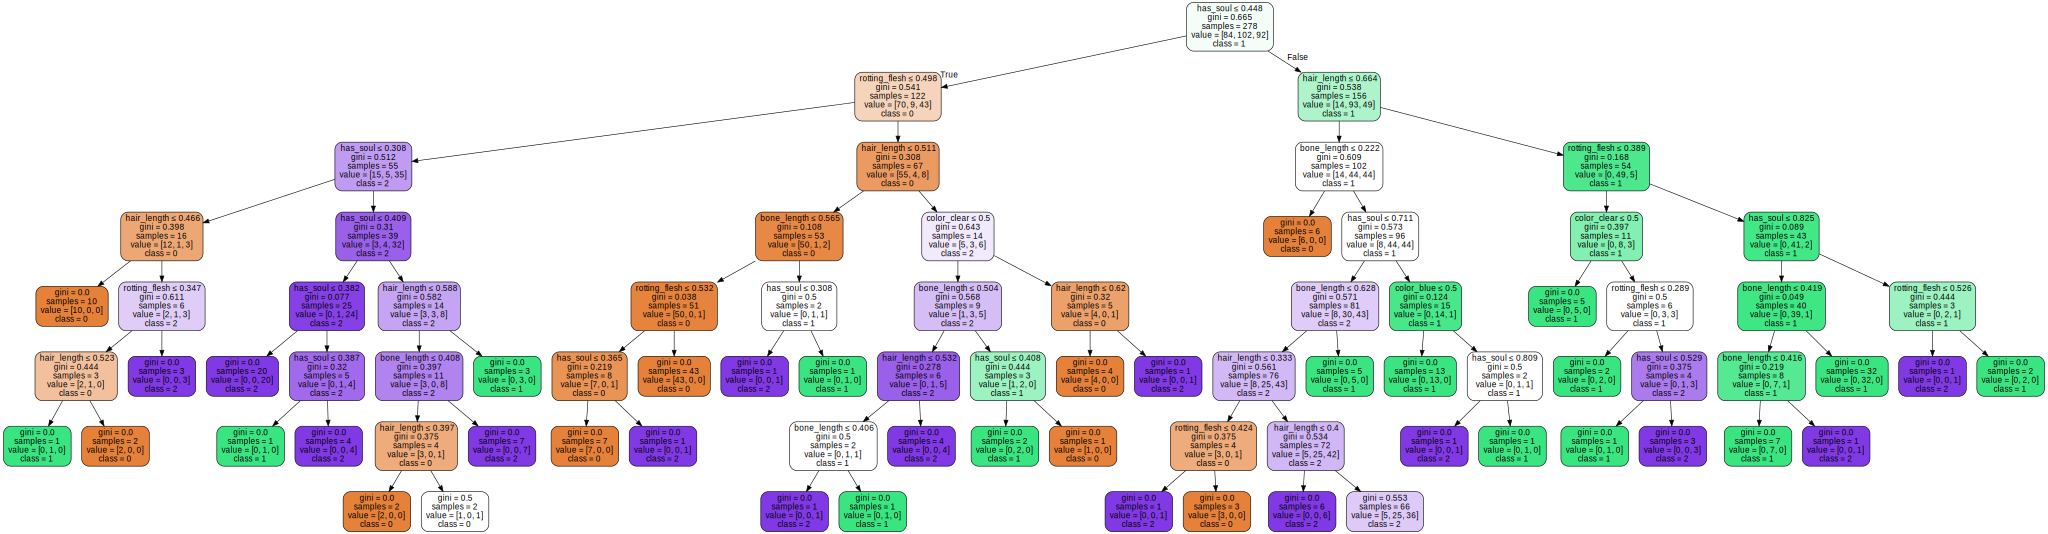

In [248]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# y_pred = dt_clf.predict(X_test)
dt_best = DecisionTreeClassifier(**clf.best_params_)
dt_best.fit(X_train, y_train)
y_pred = dt_best.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))
# print("\nRecall Score is: " + str(metrics.recall_score(y_test, y_pred, average=None)))
# print("\nPrecision Score is: " + str(metrics.precision_score(y_test, y_pred, average=None)))


# dot_data = tree.export_graphviz(dt_clf, out_file=None, feature_names=X_train.columns, class_names=['0', '1', '2'], filled=True, rounded=True, special_characters=True)
dot_data = tree.export_graphviz(dt_best, out_file=None, feature_names=X_train.columns, class_names=['0', '1', '2'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [0]:
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
# recall_scorer = metrics.make_scorer(metrics.recall_score(average=None))
# scoring = {'Recall': recall_scorer, 'Accuracy': accuracy_scorer}
# scoring = {'Accuracy': accuracy_scorer}
# scoring = ['accuracy', 'recall', 'precision']

## RandomForestClassifier

Алгоритм, использующий ансамбль решающих деревьев. Алгоритм сочетает в себе метод бэггинга и метод случайных подпространств: из выборки выбирается N подвыборок, а из них признаки. На таких подвыборках обучаются решающие деревья. После чего полученные деревья выбирают класс методом голосования.

In [250]:
%%time
params = {'n_estimators':[10, 20, 50, 100], 'criterion':['gini', 'entropy'], 'max_depth':[None, 5, 10, 25, 50], 'random_state': [0]}
rf = RandomForestClassifier(random_state = 0)
clf = GridSearchCV(rf, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 479 ms, sys: 17.3 ms, total: 496 ms
Wall time: 9.4 s


In [0]:
rf_best = RandomForestClassifier(**clf.best_params_)

In [252]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# rf_best = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_best = RandomForestClassifier(**clf.best_params_)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))
# print("\nRecall Score is: " + str(metrics.recall_score(y_test, y_pred, average=None)))
# print("\nPrecision Score is: " + str(metrics.precision_score(y_test, y_pred, average=None)))

Best score: 0.7158273381294964
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'random_state': 0}
              precision    recall  f1-score   support

       Ghost       0.85      0.85      0.85        33
       Ghoul       0.67      0.81      0.73        27
      Goblin       0.67      0.55      0.60        33

   micro avg       0.73      0.73      0.73        93
   macro avg       0.73      0.74      0.73        93
weighted avg       0.73      0.73      0.73        93


Accuracy Score (on valid) is: 0.7311827956989247


## BaggingClassifier

При бэгинге выборка разделяется на N частей, и на каждой из части обучается отдельный классификатор. При классификации каждый классификатор выдаёт ответ, и их ответы усредняются.

In [253]:
%%time
params = {'n_estimators':[10, 25, 50, 100], 'max_samples':[1, 3, 5, 10], 'random_state': [0]}
bag = BaggingClassifier(random_state = 0)
clf = GridSearchCV(bag, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 150 ms, sys: 5.25 ms, total: 155 ms
Wall time: 3.2 s


In [0]:
bag_best = BaggingClassifier(**clf.best_params_)

In [255]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# bag_best = BaggingClassifier(max_samples = 5, n_estimators = 25, random_state = 0)
bag_best = BaggingClassifier(**clf.best_params_)
bag_best.fit(X_train, y_train)
y_pred = bag_best.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

Best score: 0.6942446043165468
Best parameters: {'max_samples': 10, 'n_estimators': 50, 'random_state': 0}
              precision    recall  f1-score   support

       Ghost       0.93      0.85      0.89        33
       Ghoul       0.66      0.93      0.77        27
      Goblin       0.72      0.55      0.62        33

   micro avg       0.76      0.76      0.76        93
   macro avg       0.77      0.77      0.76        93
weighted avg       0.78      0.76      0.76        93


Accuracy Score (on valid) is: 0.7634408602150538


## GradientBoostingClassifier

При бустинге последовательно строятся классификаторы, которые обучаются на ошибках предыдущих, таким образом пытаясь компенсировать их недостатки. В основе алгоритма лежит последовательное уточнение функции, представляющей собой линейную комбинацию базовых классификаторов, с тем, чтобы минимизировать функцию потерь.

In [256]:
%%time
params = {'learning_rate':[0.05, 0.1, 0.5], 'n_estimators':[100, 200, 500], 'max_depth':[2, 3, 5, 10], 'random_state': [0]}
gbc = GradientBoostingClassifier(random_state = 0)
clf = GridSearchCV(gbc, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 1.06 s, sys: 25.4 ms, total: 1.09 s
Wall time: 1min 11s


In [0]:
gbc_best = GradientBoostingClassifier(**clf.best_params_)

In [258]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# gbc_best = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 100, random_state = 0)
gbc_best = GradientBoostingClassifier(**clf.best_params_)
gbc_best.fit(X_train, y_train)
y_pred = gbc_best.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

Best score: 0.7050359712230215
Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'random_state': 0}
              precision    recall  f1-score   support

       Ghost       0.82      0.85      0.84        33
       Ghoul       0.71      0.74      0.73        27
      Goblin       0.71      0.67      0.69        33

   micro avg       0.75      0.75      0.75        93
   macro avg       0.75      0.75      0.75        93
weighted avg       0.75      0.75      0.75        93


Accuracy Score (on valid) is: 0.7526881720430108


## KNeighborsClassifier

Классификация k-ближайших соседей - объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента.

In [259]:
%%time
params = {'n_neighbors':[3, 5, 10, 20], 'leaf_size':[20, 30, 50], 'p':[1, 2, 5], 'weights':['uniform', 'distance']}
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 267 ms, sys: 4.33 ms, total: 272 ms
Wall time: 4.36 s


In [0]:
knc_best = KNeighborsClassifier(**clf.best_params_)

In [261]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# knc_best = KNeighborsClassifier(n_neighbors = 10)
knc_best = KNeighborsClassifier(**clf.best_params_)
knc_best.fit(X_train, y_train)
y_pred = knc_best.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))
# print(knc_best.get_params())

Best score: 0.7014388489208633
Best parameters: {'leaf_size': 20, 'n_neighbors': 20, 'p': 5, 'weights': 'uniform'}
              precision    recall  f1-score   support

       Ghost       0.89      0.76      0.82        33
       Ghoul       0.67      0.89      0.76        27
      Goblin       0.66      0.58      0.61        33

   micro avg       0.73      0.73      0.73        93
   macro avg       0.74      0.74      0.73        93
weighted avg       0.74      0.73      0.73        93


Accuracy Score (on valid) is: 0.7311827956989247


## LogisticRegression

Логистическая регрессия - это статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём подгонки данных к логистической кривой. Задача обучения линейного классификатора заключается в том, чтобы по выборке настроить вектор весов. В логистической регрессии для этого решается задача минимизации эмпирического риска.

In [262]:
%%time
params = {'penalty':['l1', 'l2'], 'C':[1, 2, 3, 5, 10], 'random_state': [0]}
lr = LogisticRegression(random_state = 0)
clf = GridSearchCV(lr, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 86.2 ms, sys: 3.9 ms, total: 90.1 ms
Wall time: 554 ms


In [0]:
lr_best = LogisticRegression(**clf.best_params_)

In [264]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# lr_best = LogisticRegression(penalty = 'l1', C = 1, random_state = 0)
lr_best = LogisticRegression(**clf.best_params_)
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

Best score: 0.7230215827338129
Best parameters: {'C': 2, 'penalty': 'l1', 'random_state': 0}
              precision    recall  f1-score   support

       Ghost       0.84      0.94      0.89        33
       Ghoul       0.67      0.89      0.76        27
      Goblin       0.75      0.45      0.57        33

   micro avg       0.75      0.75      0.75        93
   macro avg       0.75      0.76      0.74        93
weighted avg       0.76      0.75      0.74        93


Accuracy Score (on valid) is: 0.7526881720430108


## SVC

Метод опорных векторов строит разделяющую гиперплоскость, максимизирующую расстояние до двух параллельных гиперплоскостей. Две данные параллельные гиперплоскости строятся по обеим сторонам разделяющей гиперплоскости, таким образом, чтобы проходить через "крайние" элементы классов, и расстояние между ними было бы максимальным.


In [265]:
%%time
params = {'kernel':['linear', 'rbf'], 'C':[1, 3, 5, 10], 'degree':[3, 5, 10], 'random_state': [0]}
svc = SVC(probability = True, random_state = 0)
clf = GridSearchCV(svc, param_grid = params, scoring = accuracy_scorer, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 137 ms, sys: 4.58 ms, total: 142 ms
Wall time: 1.48 s


In [0]:
svc_best = SVC(**clf.best_params_)

In [267]:
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

# svc_best = SVC(C = 10, degree = 3, kernel = 'linear', probability = True, random_state = 0)
svc_best = SVC(**clf.best_params_)
svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

Best score: 0.7266187050359713
Best parameters: {'C': 10, 'degree': 3, 'kernel': 'linear', 'random_state': 0}
              precision    recall  f1-score   support

       Ghost       0.91      0.88      0.89        33
       Ghoul       0.77      0.74      0.75        27
      Goblin       0.69      0.73      0.71        33

   micro avg       0.78      0.78      0.78        93
   macro avg       0.79      0.78      0.78        93
weighted avg       0.79      0.78      0.79        93


Accuracy Score (on valid) is: 0.7849462365591398


Сравнение алгоритмов на валидационной выборке.

In [268]:
y_pred = dt_best.predict(X_test)
print("\nAccuracy Score DT (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = rf_best.predict(X_test)
print("\nAccuracy Score RF (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = bag_best.predict(X_test)
print("\nAccuracy Score BAG (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = gbc_best.predict(X_test)
print("\nAccuracy Score GBC (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = knc_best.predict(X_test)
print("\nAccuracy Score kNC (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = lr_best.predict(X_test)
print("\nAccuracy Score LR (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))

y_pred = svc_best.predict(X_test)
print("\nAccuracy Score SVC (on valid) is: " + str(metrics.accuracy_score(y_test, y_pred)))


Accuracy Score DT (on valid) is: 0.5806451612903226

Accuracy Score RF (on valid) is: 0.7311827956989247

Accuracy Score BAG (on valid) is: 0.7634408602150538

Accuracy Score GBC (on valid) is: 0.7526881720430108

Accuracy Score kNC (on valid) is: 0.7311827956989247

Accuracy Score LR (on valid) is: 0.7526881720430108

Accuracy Score SVC (on valid) is: 0.7849462365591398


# VotingClassifier

Выбрав наилучшие параметры для различных классификаторов, будем используем VotingClassifier, чтобы выбирать наилучший результат для каждойго объекта (параметр 'hard')

In [269]:
%%time
# voting_clf = VotingClassifier(estimators=[('dt', dt_best), ('rf', rf_best), ('bag', bag_best), ('gbc', gbc_best), ('lr', lr_best), ('svc', svc_best)]
#                               , voting='hard')
voting_clf = VotingClassifier(estimators=[('rf', rf_best), ('bag', bag_best), ('gbc', gbc_best), ('lr', lr_best), ('svc', svc_best)]
                              , voting='hard')
voting_clf.fit(X_train, y_train)

CPU times: user 280 ms, sys: 1.76 ms, total: 282 ms
Wall time: 284 ms


In [270]:
y_pred = voting_clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("\nAccuracy Score for VotingClassifier is: " + str(voting_clf.score(X_train, y_train)))

              precision    recall  f1-score   support

       Ghost       0.86      0.91      0.88        33
       Ghoul       0.72      0.85      0.78        27
      Goblin       0.77      0.61      0.68        33

   micro avg       0.78      0.78      0.78        93
   macro avg       0.78      0.79      0.78        93
weighted avg       0.79      0.78      0.78        93


Accuracy Score for VotingClassifier is: 0.8273381294964028


## Блок для предсказания на тестовой выборке

In [271]:
X_train = pd.get_dummies(train_data.drop('type', axis = 1))
y_train = train_data['type']
X_test = pd.get_dummies(test_data)

# voting_clf = VotingClassifier(estimators=[('dt', dt_best), ('rf', rf_best), ('bag', bag_best), ('gbc', gbc_best), ('lr', lr_best), ('svc', svc_best)]
#                               , voting='hard')
voting_clf = VotingClassifier(estimators=[('rf', rf_best), ('bag', bag_best), ('gbc', gbc_best), ('lr', lr_best), ('svc', svc_best)]
                              , voting='hard')
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
print("\nAccuracy Score for VotingClassifier is: " + str(voting_clf.score(X_train, y_train)))

submission = pd.DataFrame({'id':test_data_orig['id'], 'type':y_pred})
submission.to_csv('submission.csv', index=False)
submission
# files.download('submission.csv')


Accuracy Score for VotingClassifier is: 0.8086253369272237


,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghost
4,13,Ghost
5,14,Ghost
6,15,Ghoul
7,16,Ghoul
8,17,Goblin
9,18,Ghoul


# Результаты

С помощью голосующего классификатора удалось получить Accuracy =  0.74102, которая была получена на сайте Kaggle.com, на тестовой выборке.

На валидационной выборке лучшим классификатором оказался метод опорных векторов, который получил Accuracy = 0.784946.